In [203]:
import boto3
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import sagemaker
import time
import sagemaker
import pandas as pd
from sagemaker import get_execution_role
import numpy as np
import matplotlib.pyplot as plt
import os
import tarfile
from IPython.display import display, HTML
import random
import matplotlib.image as mpimg
import io
from PIL import Image
import requests
from sagemaker.feature_store.feature_definition import FeatureDefinition, FeatureTypeEnum
from sagemaker.feature_store.feature_group import FeatureGroup
from time import gmtime, strftime
import boto3
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import sagemaker
from sagemaker.estimator import Estimator
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.predictor import Predictor
from sklearn.metrics import classification_report

In [204]:
# Create S3 Bucket
session = boto3.session.Session()
region = session.region_name
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

s3 = boto3.Session().client(service_name="s3", region_name=region)

In [205]:
print("Default bucket: {}".format(bucket))

Default bucket: sagemaker-us-east-1-001188301630


In [206]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [207]:
s3_private_path = "s3://{}/data".format(bucket)
print(s3_private_path)

s3://sagemaker-us-east-1-001188301630/data


In [208]:
!aws s3 cp "./data" $s3_private_path/ --recursive

upload: data/benign/1006.jpg to s3://sagemaker-us-east-1-001188301630/data/benign/1006.jpg
upload: data/benign/1.jpg to s3://sagemaker-us-east-1-001188301630/data/benign/1.jpg   
upload: data/benign/10.jpg to s3://sagemaker-us-east-1-001188301630/data/benign/10.jpg
upload: data/benign/1013.jpg to s3://sagemaker-us-east-1-001188301630/data/benign/1013.jpg
upload: data/benign/1003.jpg to s3://sagemaker-us-east-1-001188301630/data/benign/1003.jpg
upload: data/benign/1018.jpg to s3://sagemaker-us-east-1-001188301630/data/benign/1018.jpg
upload: data/benign/1061.jpg to s3://sagemaker-us-east-1-001188301630/data/benign/1061.jpg
upload: data/benign/1055.jpg to s3://sagemaker-us-east-1-001188301630/data/benign/1055.jpg
upload: data/benign/1070.jpg to s3://sagemaker-us-east-1-001188301630/data/benign/1070.jpg
upload: data/benign/1033.jpg to s3://sagemaker-us-east-1-001188301630/data/benign/1033.jpg
upload: data/benign/1019.jpg to s3://sagemaker-us-east-1-001188301630/data/benign/1019.jpg
upload

In [209]:
!aws s3 ls $s3_private_path/

                           PRE /
                           PRE benign/
                           PRE malignant/
                           PRE output/
                           PRE test/
                           PRE train/
                           PRE validation/


In [210]:
display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/sagemaker-{}-{}/data/?region={}&tab=overview">S3 Bucket</a></b>'.format(
            region, account_id, region
        )
    )
)

# EDA

Class distribution:
label
malignant    1130
benign        755
Name: count, dtype: int64


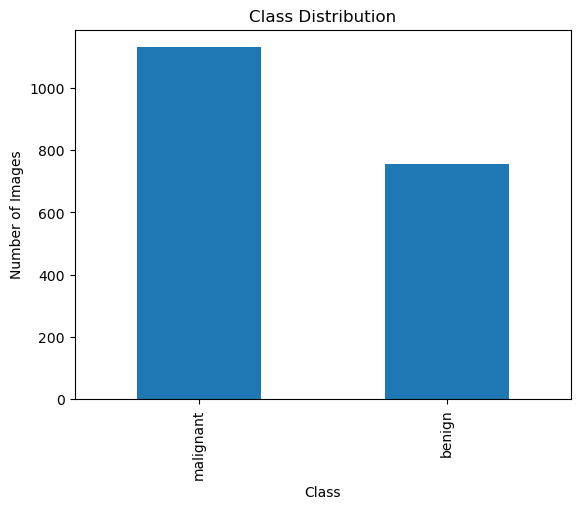

In [211]:
data_prefix = "data/"  # Ensure this points to the root of your data folder

# Create a client to interact with S3
s3 = boto3.client('s3')

# Initialize lists to store image paths and labels
image_paths = []
labels = []

# Initialize pagination for listing all objects
paginator = s3.get_paginator('list_objects_v2')
pages = paginator.paginate(Bucket=bucket, Prefix=data_prefix)

# Collect image file paths and labels based on S3 keys
for page in pages:
    for obj in page.get('Contents', []):
        if obj['Key'].endswith('.jpg') or obj['Key'].endswith('.png'):
            image_path = f"s3://{bucket}/{obj['Key']}"
            image_paths.append(image_path)
            
            # Assuming folder structure is data/class_name/image.jpg
            label = obj['Key'].split('/')[-2]
            labels.append(label)

# Create a DataFrame to store image paths and labels
df = pd.DataFrame({'image_path': image_paths, 'label': labels})

# Check the distribution of classes
class_distribution = df['label'].value_counts()
print("Class distribution:")
print(class_distribution)

# Plot the class distribution
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

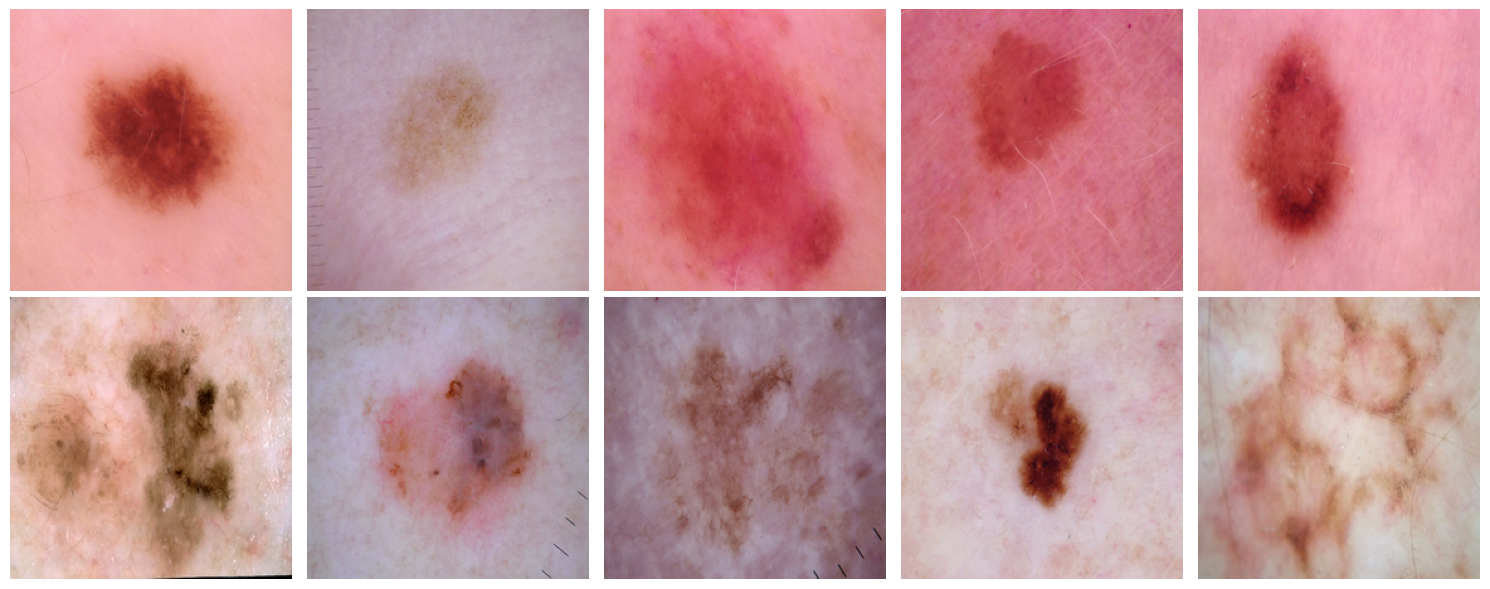

In [212]:
# Use boto3 to access the S3 images
s3 = boto3.client('s3')

def load_image_from_s3(s3_url):
    # Parse the S3 URL
    bucket_name = s3_url.split('/')[2].split('.')[0]
    key = '/'.join(s3_url.split('/')[3:])

    # Get the image object from S3
    obj = s3.get_object(Bucket=bucket_name, Key=key)
    
    # Read the image content and return it as an Image object
    img_data = obj['Body'].read()
    img = Image.open(io.BytesIO(img_data))
    
    return img

def show_sample_images(df, num_samples=5):
    classes = df['label'].unique()
    fig, axs = plt.subplots(len(classes), num_samples, figsize=(num_samples*3, len(classes)*3))

    for i, cls in enumerate(classes):
        cls_df = df[df['label'] == cls]
        samples = cls_df.sample(num_samples)
        for j, (_, row) in enumerate(samples.iterrows()):
            img = load_image_from_s3(row['image_path'])  # Load image from S3
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            if j == 0:
                axs[i, j].set_ylabel(cls, size='large')

    plt.tight_layout()
    plt.show()

# Show sample images
show_sample_images(df)

# Feature Engineering | Feature Store | Feature Group

In [213]:
feature_store_session = sagemaker_session

# Define the feature group
feature_group_name = 'skin-cancer-feature-group' + strftime('%d-%H-%M-%S', gmtime())
feature_group = FeatureGroup(name=feature_group_name, sagemaker_session=feature_store_session)

# Function to extract features from each image
def extract_features(row):
    # Read image from S3
    key_path = '/'.join(row['image_path'].split('/')[3:])
    s3_object = s3.get_object(Bucket=bucket, Key=key_path)
    img = Image.open(io.BytesIO(s3_object['Body'].read()))
    img_array = np.array(img)

    # Extract image features
    height, width = img.size
    mean_pixel_value = img_array.mean()

    return pd.Series({
        'image_path': row['image_path'],
        'label': row['label'],
        'height': height,
        'width': width,
        'mean_pixel_value': mean_pixel_value
    })

# Assume df is your initial DataFrame containing the image paths and labels
features_df = df.apply(extract_features, axis=1)

# Set up event time and record identifier
record_identifier_name = 'image_path'
event_time_feature_name = 'event_time'

# Ensure the event time is in the correct ISO-8601 format with timezone
features_df[event_time_feature_name] = pd.to_datetime('now', utc=True).strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] + 'Z'

# Create the feature group
feature_group.load_feature_definitions(data_frame=features_df)

# Create the feature group in SageMaker Feature Store
feature_group.create(
    s3_uri=f's3://{bucket}/{data_prefix}/feature-store',
    record_identifier_name=record_identifier_name,
    event_time_feature_name=event_time_feature_name,
    role_arn=role,
    enable_online_store=True
)

# Function to check the status of the feature group
def wait_for_feature_group_creation(feature_group):
    status = 'Creating'
    while status not in ['Created', 'CreateFailed']:
        description = feature_group.describe()
        status = description['FeatureGroupStatus']
        if status == 'Created':
            print(f"Feature group '{feature_group_name}' successfully created.")
            break
        elif status == 'CreateFailed':
            raise Exception(f"Feature group '{feature_group_name}' creation failed.")
        print(f"Waiting for feature group '{feature_group_name}' creation. Current status: {status}")
        time.sleep(10)  # Check every 10 seconds

# Wait for the feature group to be created
wait_for_feature_group_creation(feature_group)

# Ingest the DataFrame directly into the Feature Store
feature_group.ingest(data_frame=features_df, max_workers=5, wait=True)

print(f"Features successfully ingested into Feature Group: {feature_group_name}")


Waiting for feature group 'skin-cancer-feature-group15-02-32-35' creation. Current status: Creating
Waiting for feature group 'skin-cancer-feature-group15-02-32-35' creation. Current status: Creating
Waiting for feature group 'skin-cancer-feature-group15-02-32-35' creation. Current status: Creating
Waiting for feature group 'skin-cancer-feature-group15-02-32-35' creation. Current status: Creating
Feature group 'skin-cancer-feature-group15-02-32-35' successfully created.


INFO:sagemaker.feature_store.feature_group:Started ingesting index 1508 to 1885
INFO:sagemaker.feature_store.feature_group:Started ingesting index 377 to 754
INFO:sagemaker.feature_store.feature_group:Started ingesting index 754 to 1131
INFO:sagemaker.feature_store.feature_group:Started ingesting index 1131 to 1508
INFO:sagemaker.feature_store.feature_group:Started ingesting index 0 to 377
INFO:sagemaker.feature_store.feature_group:Successfully ingested row 377 to 754
INFO:sagemaker.feature_store.feature_group:Successfully ingested row 1131 to 1508
INFO:sagemaker.feature_store.feature_group:Successfully ingested row 754 to 1131
INFO:sagemaker.feature_store.feature_group:Successfully ingested row 0 to 377
INFO:sagemaker.feature_store.feature_group:Successfully ingested row 1508 to 1885


Features successfully ingested into Feature Group: skin-cancer-feature-group15-02-32-35


# Benchmark Model

In [214]:
from sklearn.model_selection import train_test_split

# First, split off production data (40%)
train_val_df, prod_df = train_test_split(features_df, test_size=0.4, stratify=features_df['label'], random_state=42)

# Then split the remaining data
train_df, temp_df = train_test_split(train_val_df, test_size=0.2, stratify=train_val_df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# Verify the splits
print(f"Training set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")
print(f"Production set: {len(prod_df)} samples")


Training set: 904 samples
Validation set: 113 samples
Test set: 114 samples
Production set: 754 samples


In [215]:
# Select simple features
benchmark_features = ['mean_pixel_value']

# Prepare datasets
X_train = train_df[benchmark_features]
y_train = train_df['label']

X_val = val_df[benchmark_features]
y_val = val_df['label']

X_test = test_df[benchmark_features]
y_test = test_df['label']

In [216]:
# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

# Train logistic regression benchmark model
benchmark_model = LogisticRegression()
benchmark_model.fit(X_train, y_train_enc)

# Evaluate on validation set
val_score = benchmark_model.score(X_val, y_val_enc)
print(f"Validation Accuracy of Benchmark Model: {val_score}")

Validation Accuracy of Benchmark Model: 0.5929203539823009


## Improved Model

In [217]:
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import dump_svmlight_file

# Encoding labels as numbers
le = LabelEncoder()
y_train_encoded = le.fit_transform(train_df['label'])
y_val_encoded = le.transform(val_df['label'])
y_test_encoded = le.transform(test_df['label'])

# Select features for the LIBSVM format (excluding 'label' and non-feature columns)
features = train_df.drop(['label', 'image_path', 'event_time'], axis=1)

# Save the datasets in LIBSVM format
dump_svmlight_file(features, y_train_encoded, 'train.libsvm')
dump_svmlight_file(val_df[features.columns], y_val_encoded, 'validation.libsvm')
dump_svmlight_file(test_df[features.columns], y_test_encoded, 'test.libsvm')

# Upload to S3
s3_resource = boto3.resource('s3')
s3_resource.Bucket(bucket).Object('data/train/train.libsvm').upload_file('train.libsvm')
s3_resource.Bucket(bucket).Object('data/validation/validation.libsvm').upload_file('validation.libsvm')
s3_resource.Bucket(bucket).Object('data/test/test.libsvm').upload_file('test.libsvm')

# Define the S3 paths for the LIBSVM files
s3_train_path = f's3://{bucket}/data/train/train.libsvm'
s3_val_path = f's3://{bucket}/data/validation/validation.libsvm'
s3_test_path = f's3://{bucket}/data/test/test.libsvm'

# Configure the Estimator
xgboost_estimator = Estimator(
    image_uri=sagemaker.image_uris.retrieve("xgboost", region, version="1.5-1"),
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{bucket}/data/output',
    hyperparameters={
        'objective': 'binary:logistic',
        'num_round': 100
    }
)

# Start training
xgboost_estimator.fit({'train': s3_train_path, 'validation': s3_val_path})


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-10-15-02-35-11-895


2024-10-15 02:35:12 Starting - Starting the training job...
2024-10-15 02:35:28 Starting - Preparing the instances for training...
2024-10-15 02:35:50 Downloading - Downloading input data...
2024-10-15 02:36:31 Downloading - Downloading the training image......
2024-10-15 02:37:37 Training - Training image download completed. Training in progress.
2024-10-15 02:37:37 Uploading - Uploading generated training model/miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[2024-10-15 02:37:32.030 ip-10-0-233-39.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-10-15 02:37:32.061 ip-10-0-233-39.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2024-10-15:02:37:32:INFO] Imported framework sagemaker_xgboost_container.training
[2024-10-15:02

# Endpoint creation | Model Deployment

In [219]:
%%time

from datetime import datetime, timedelta, timezone
import json
import os
import re
import boto3
from time import sleep
from threading import Thread

import pandas as pd

from sagemaker import get_execution_role, session, Session, image_uris
from sagemaker.s3 import S3Downloader, S3Uploader
from sagemaker.processing import ProcessingJob
from sagemaker.serializers import CSVSerializer

from sagemaker.model import Model
from sagemaker.model_monitor import DataCaptureConfig

session = Session()

CPU times: user 33.2 ms, sys: 0 ns, total: 33.2 ms
Wall time: 41.5 ms


In [220]:
# Setup S3 bucket
# You can use a different bucket, but make sure the role you chose for this notebook
# has the s3:PutObject permissions. This is the bucket into which the data is captured
bucket = session.default_bucket()
print("Demo Bucket:", bucket)

##S3 prefixes
data_capture_prefix = f"{prefix}/datacapture"
s3_capture_upload_path = f"s3://{bucket}/{data_capture_prefix}"

ground_truth_upload_path = (
    f"s3://{bucket}/{prefix}/ground_truth_data/{datetime.now():%Y-%m-%d-%H-%M-%S}"
)

reports_prefix = f"{prefix}/reports"
s3_report_path = f"s3://{bucket}/{reports_prefix}"

##Get the model monitor image
monitor_image_uri = image_uris.retrieve(framework="model-monitor", region=region)

print("Image URI:", monitor_image_uri)
print(f"Capture path: {s3_capture_upload_path}")
print(f"Ground truth path: {ground_truth_upload_path}")
print(f"Report path: {s3_report_path}")

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Demo Bucket: sagemaker-us-east-1-001188301630
Image URI: 156813124566.dkr.ecr.us-east-1.amazonaws.com/sagemaker-model-monitor-analyzer
Capture path: s3://sagemaker-us-east-1-001188301630/sagemaker/Malignant-Cancerous-ModelQualityMonitor-20241410/datacapture
Ground truth path: s3://sagemaker-us-east-1-001188301630/sagemaker/Malignant-Cancerous-ModelQualityMonitor-20241410/ground_truth_data/2024-10-15-02-39-12
Report path: s3://sagemaker-us-east-1-001188301630/sagemaker/Malignant-Cancerous-ModelQualityMonitor-20241410/reports


In [221]:
data_capture_config = DataCaptureConfig(
    enable_capture=True, sampling_percentage=100, destination_s3_uri=s3_capture_upload_path
)

In [224]:
# 1. Deploy the model to create an endpoint
endpoint_name = 'xgboost-skin-cancer-prediction-4'
predictor = xgboost_estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    endpoint_name=endpoint_name,
    serializer=CSVSerializer(),
    deserializer=JSONDeserializer(),
    data_capture_config=data_capture_config,
)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-10-15-02-40-01-215
INFO:sagemaker:Creating endpoint-config with name xgboost-skin-cancer-prediction-4
INFO:sagemaker:Creating endpoint with name xgboost-skin-cancer-prediction-4


-------!

In [225]:
test_data = X_test.values.tolist()  # Convert DataFrame to list of lists (if not already)

# Function to predict using the deployed model
def model_predict(data, predictor):
    payload = ','.join(map(str, data))
    prediction = predictor.predict(payload)
    return prediction['predictions'][0]  # This returns the first prediction in the list

# Use the modified function to make predictions on your test data
predictions = [extract_prediction(model_predict(row, predictor)) for row in test_data]

# Since the predictions are already binary (0 or 1), you can directly compare them with the encoded labels
encoder = LabelEncoder()
true_labels_encoded = encoder.fit_transform(test_df['label'])  # Ensure this column contains the correct labels

# Evaluate predictions using classification report
from sklearn.metrics import classification_report
print(classification_report(true_labels_encoded, predictions, zero_division=0))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        46
           1       0.60      1.00      0.75        68

    accuracy                           0.60       114
   macro avg       0.30      0.50      0.37       114
weighted avg       0.36      0.60      0.45       114



In [152]:
print(len(true_labels_encoded))

114


In [153]:
print(len(predictions))

114


In [227]:
validation_with_predictions = pd.DataFrame({'labels': true_labels_encoded})
validation_with_predictions

,labels
0,1
1,1
2,0
3,1
4,1
...,...
109,0
110,0
111,1
112,1


In [228]:
validation_with_predictions['prediction'] = predictions

In [229]:
validation_with_predictions

,labels,prediction
0,1,1
1,1,1
2,0,1
3,1,1
4,1,1
...,...,...
109,0,1
110,0,1
111,1,1
112,1,1


In [157]:
validation_with_predictions.to_csv('validation_with_predictions.csv')

# Compare Against Benchmark Model

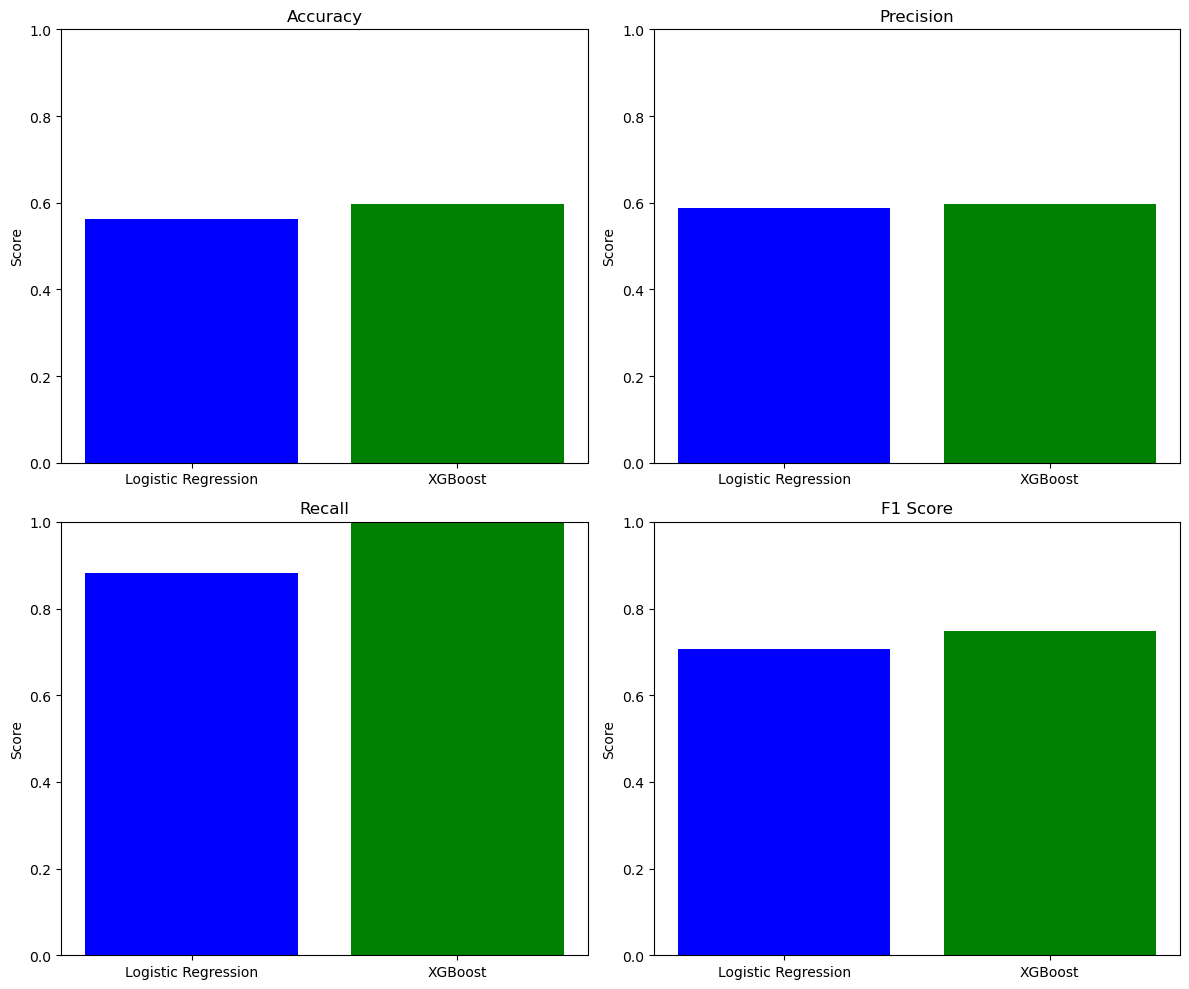

In [226]:
# Ensure you have imported necessary functions
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define X_test_benchmark if it differs from X_test; otherwise, use X_test directly
X_test_benchmark = X_test  # Assuming X_test is your benchmark test dataset

# Get predictions for the logistic regression model
y_pred_benchmark = benchmark_model.predict(X_test_benchmark)
y_pred_benchmark_prob = benchmark_model.predict_proba(X_test_benchmark)[:, 1]

# Convert X_test_benchmark to the required numpy array format for XGBoost predictions
xgboost_predictions = predictor.predict(X_test_benchmark.to_numpy())

# Assuming the xgboost_predictions is structured as a dictionary with 'predictions' key
# Each prediction in 'predictions' list is assumed to have a 'score' key for binary classification
y_pred_xgboost = [int(round(p['score'])) for p in xgboost_predictions['predictions']]

# Calculate metrics
metrics = {
    'Accuracy': (accuracy_score(y_test_enc, y_pred_benchmark), accuracy_score(y_test_enc, y_pred_xgboost)),
    'Precision': (precision_score(y_test_enc, y_pred_benchmark), precision_score(y_test_enc, y_pred_xgboost)),
    'Recall': (recall_score(y_test_enc, y_pred_benchmark), recall_score(y_test_enc, y_pred_xgboost)),
    'F1 Score': (f1_score(y_test_enc, y_pred_benchmark), f1_score(y_test_enc, y_pred_xgboost))
}

# Create bar plots for each metric
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax = ax.ravel()

for i, (metric, values) in enumerate(metrics.items()):
    ax[i].bar(['Logistic Regression', 'XGBoost'], values, color=['blue', 'green'])
    ax[i].set_title(f'{metric}')
    ax[i].set_ylim(0, 1)
    ax[i].set_ylabel('Score')

plt.tight_layout()
plt.show()


In [ ]:
# Clean up
# sagemaker.Session().delete_endpoint(predictor.endpoint_name)

# Model Monitoring and Reports

In [ ]:
# TODO

'''
Implement model monitors on your ML system.
Implement data monitors on your ML system.
Implement infrastructure monitors on your ML system.
Create a monitoring dashboard for your ML endpoint/job on Cloudwatch
Generate model and data reports on SageMaker.
Update and post the tracker to the Team Project Update.


In [230]:
!head validation_with_predictions.csv

,labels,prediction
0,1,1
1,1,1
2,0,1
3,1,1
4,1,1
5,1,1
6,1,1
7,0,1
8,1,1


In [231]:
validation_df = pd.read_csv('validation_with_predictions.csv')
validation_df.head()

,Unnamed: 0,labels,prediction
0,0,1,1
1,1,1,1
2,2,0,1
3,3,1,1
4,4,1,1


In [232]:
prefix = "sagemaker/Malignant-Cancerous-ModelQualityMonitor-20241410"

baseline_prefix = prefix + "/baselining"
baseline_data_prefix = baseline_prefix + "/data"
baseline_results_prefix = baseline_prefix + "/results"

baseline_data_uri = f"s3://{bucket}/{baseline_data_prefix}"
baseline_results_uri = f"s3://{bucket}/{baseline_results_prefix}"
print(f"Baseline data uri: {baseline_data_uri}")
print(f"Baseline results uri: {baseline_results_uri}")

Baseline data uri: s3://sagemaker-us-east-1-001188301630/sagemaker/Malignant-Cancerous-ModelQualityMonitor-20241410/baselining/data
Baseline results uri: s3://sagemaker-us-east-1-001188301630/sagemaker/Malignant-Cancerous-ModelQualityMonitor-20241410/baselining/results


In [233]:
baseline_dataset_uri = S3Uploader.upload("validation_with_predictions.csv", baseline_data_uri)
baseline_dataset_uri

's3://sagemaker-us-east-1-001188301630/sagemaker/Malignant-Cancerous-ModelQualityMonitor-20241410/baselining/data/validation_with_predictions.csv'

In [234]:
from sagemaker.model_monitor import ModelQualityMonitor
from sagemaker.model_monitor import EndpointInput
from sagemaker.model_monitor.dataset_format import DatasetFormat

from datetime import datetime, timedelta, timezone
import json
import os
import re
import boto3
from time import sleep
from threading import Thread

import pandas as pd

from sagemaker import get_execution_role, session, Session, image_uris
from sagemaker.s3 import S3Downloader, S3Uploader
from sagemaker.processing import ProcessingJob
from sagemaker.serializers import CSVSerializer

from sagemaker.model import Model
from sagemaker.model_monitor import DataCaptureConfig

session = Session()

In [235]:
# Create the model quality monitoring object
churn_model_quality_monitor = ModelQualityMonitor(
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    volume_size_in_gb=20,
    max_runtime_in_seconds=1800,
    sagemaker_session=session,
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [236]:
# Name of the model quality baseline job
baseline_job_name = f"malignant-cancerous-model-baseline-job-{datetime.utcnow():%Y-%m-%d-%H%M}"

In [237]:
# Execute the baseline suggestion job.
# You will specify problem type, in this case Binary Classification, and provide other required attributes.
job = churn_model_quality_monitor.suggest_baseline(
    job_name=baseline_job_name,
    baseline_dataset=baseline_dataset_uri,
    dataset_format=DatasetFormat.csv(header=True),
    output_s3_uri=baseline_results_uri,
    problem_type="BinaryClassification",
    inference_attribute="prediction",
    ground_truth_attribute="labels",
)
job.wait(logs=False)

INFO:sagemaker:Creating processing-job with name malignant-cancerous-model-baseline-job-2024-10-15-0247


...........................................................!

In [238]:
baseline_job = churn_model_quality_monitor.latest_baselining_job

In [239]:
binary_metrics = baseline_job.baseline_statistics().body_dict["binary_classification_metrics"]
pd.json_normalize(binary_metrics).T

,0
confusion_matrix.0.0,0
confusion_matrix.0.1,46
confusion_matrix.1.0,0
confusion_matrix.1.1,68
recall.value,1.0
recall.standard_deviation,None
precision.value,0.596491
precision.standard_deviation,None
accuracy.value,0.596491
accuracy.standard_deviation,None


In [240]:
pd.DataFrame(baseline_job.suggested_constraints().body_dict["binary_classification_constraints"]).T

,threshold,comparison_operator
recall,1.0,LessThanThreshold
precision,0.596491,LessThanThreshold
accuracy,0.596491,LessThanThreshold
true_positive_rate,1.0,LessThanThreshold
true_negative_rate,0.0,LessThanThreshold
false_positive_rate,1.0,GreaterThanThreshold
false_negative_rate,0.0,GreaterThanThreshold
f0_5,0.648855,LessThanThreshold
f1,0.747253,LessThanThreshold
f2,0.880829,LessThanThreshold


In [241]:
test_data_2_df['1'] = X_test.values
test_data_2_df

,1
0,116.471979
1,158.992035
2,137.855894
3,152.533017
4,136.436384
...,...
109,208.584124
110,158.334336
111,202.456500
112,110.515373


In [242]:
test_data_2_df.to_csv('validation_test_data.csv',index=False)

In [243]:
!head validation_test_data.csv

1
116.47197863520408
158.9920347045068
137.85589392006804
152.53301711309524
136.43638392857142
148.89872316113946
155.30768362032313
118.59145142431973
136.6474077912415


In [245]:
def invoke_endpoint(ep_name, file_name):
    with open(file_name, "r") as f:
        i = 0
        for row in f:
            payload = row.rstrip("\n")
            response = session.sagemaker_runtime_client.invoke_endpoint(
                EndpointName=endpoint_name,
                ContentType="text/csv",
                Body=payload,
                InferenceId=str(i),  # unique ID per row
            )["Body"].read()
            i += 1
            sleep(1)


def invoke_endpoint_forever():
    while True:
        try:
            invoke_endpoint(endpoint_name, "validation_test_data.csv")
        except session.sagemaker_runtime_client.exceptions.ValidationError:
            pass


thread = Thread(target=invoke_endpoint_forever)
thread.start()

In [246]:
print("Waiting for captures to show up", end="")
for _ in range(120):
    capture_files = sorted(S3Downloader.list(f"{s3_capture_upload_path}/{endpoint_name}"))
    if capture_files:
        capture_file = S3Downloader.read_file(capture_files[-1]).split("\n")
        capture_record = json.loads(capture_file[0])
        if "inferenceId" in capture_record["eventMetadata"]:
            break
    print(".", end="", flush=True)
    sleep(1)
print()
print("Found Capture Files:")
print("\n ".join(capture_files[-3:]))

Waiting for captures to show up..........................................
Found Capture Files:
s3://sagemaker-us-east-1-001188301630/sagemaker/Malignant-Cancerous-ModelQualityMonitor-20241410/datacapture/xgboost-skin-cancer-prediction-4/AllTraffic/2024/10/15/02/46-20-603-f472ab66-923c-45e2-9c4b-7944d63b9f28.jsonl
 s3://sagemaker-us-east-1-001188301630/sagemaker/Malignant-Cancerous-ModelQualityMonitor-20241410/datacapture/xgboost-skin-cancer-prediction-4/AllTraffic/2024/10/15/02/54-28-958-0d2427ea-22fa-48db-a675-2b54741a6a4d.jsonl


In [247]:
print("\n".join(capture_file[-3:-1]))

{"captureData":{"endpointInput":{"observedContentType":"text/csv","mode":"INPUT","data":"88.21545493197279","encoding":"CSV"},"endpointOutput":{"observedContentType":"text/csv; charset=utf-8","mode":"OUTPUT","data":"0.9549472332000732\n","encoding":"CSV"}},"eventMetadata":{"eventId":"edfee611-7a92-42ca-ac3f-f3a2cdc79e6a","inferenceId":"57","inferenceTime":"2024-10-15T02:55:27Z"},"eventVersion":"0"}
{"captureData":{"endpointInput":{"observedContentType":"text/csv","mode":"INPUT","data":"179.97339365433675","encoding":"CSV"},"endpointOutput":{"observedContentType":"text/csv; charset=utf-8","mode":"OUTPUT","data":"0.9549472332000732\n","encoding":"CSV"}},"eventMetadata":{"eventId":"6072b113-087c-4d4d-baf6-ed7f5ca04195","inferenceId":"58","inferenceTime":"2024-10-15T02:55:28Z"},"eventVersion":"0"}


In [248]:
print(json.dumps(capture_record, indent=2))

{
  "captureData": {
    "endpointInput": {
      "observedContentType": "text/csv",
      "mode": "INPUT",
      "data": "1",
      "encoding": "CSV"
    },
    "endpointOutput": {
      "observedContentType": "text/csv; charset=utf-8",
      "mode": "OUTPUT",
      "data": "0.9549472332000732\n",
      "encoding": "CSV"
    }
  },
  "eventMetadata": {
    "eventId": "eeb92c05-4f53-49b6-86da-7f2a9101633d",
    "inferenceId": "0",
    "inferenceTime": "2024-10-15T02:54:28Z"
  },
  "eventVersion": "0"
}


In [249]:
import random


def ground_truth_with_id(inference_id):
    random.seed(inference_id)  # to get consistent results
    rand = random.random()
    return {
        "groundTruthData": {
            "data": "1" if rand < 0.7 else "0",  # randomly generate positive labels 70% of the time
            "encoding": "CSV",
        },
        "eventMetadata": {
            "eventId": str(inference_id),
        },
        "eventVersion": "0",
    }


def upload_ground_truth(records, upload_time):
    fake_records = [json.dumps(r) for r in records]
    data_to_upload = "\n".join(fake_records)
    target_s3_uri = f"{ground_truth_upload_path}/{upload_time:%Y/%m/%d/%H/%M%S}.jsonl"
    print(f"Uploading {len(fake_records)} records to", target_s3_uri)
    S3Uploader.upload_string_as_file_body(data_to_upload, target_s3_uri)

In [250]:
NUM_GROUND_TRUTH_RECORDS = 500  # 500 are the number of rows in data we're sending for inference


def generate_fake_ground_truth_forever():
    j = 0
    while True:
        fake_records = [ground_truth_with_id(i) for i in range(NUM_GROUND_TRUTH_RECORDS)]
        upload_ground_truth(fake_records, datetime.utcnow())
        j = (j + 1) % 5
        sleep(60 * 60)  # do this once an hour


gt_thread = Thread(target=generate_fake_ground_truth_forever)
gt_thread.start()

Uploading 500 records to s3://sagemaker-us-east-1-001188301630/sagemaker/Malignant-Cancerous-ModelQualityMonitor-20241410/ground_truth_data/2024-10-15-02-53-43/2024/10/15/02/5813.jsonl


In [251]:
##Monitoring schedule name
churn_monitor_schedule_name = (
    f"skin-cancer-monitoring-schedule-{datetime.utcnow():%Y-%m-%d-%H%M}"
)

In [265]:
# Create an enpointInput
endpointInput = EndpointInput(
    endpoint_name=predictor.endpoint_name,
    probability_attribute="0",
    probability_threshold_attribute=0.99,
    destination="/opt/ml/processing/input_data",
)

In [268]:
# Create the monitoring schedule to execute every hour.
from sagemaker.model_monitor import CronExpressionGenerator

response = churn_model_quality_monitor.create_monitoring_schedule(
    monitor_schedule_name=churn_monitor_schedule_name,
    endpoint_input=endpointInput,
    output_s3_uri=baseline_results_uri,
    problem_type="BinaryClassification",
    ground_truth_input=ground_truth_upload_path,
    constraints=baseline_job.suggested_constraints(),
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    enable_cloudwatch_metrics=True,
)

INFO:sagemaker.model_monitor.model_monitoring:Creating Monitoring Schedule with name: skin-cancer-monitoring-schedule-2024-10-15-0258


In [269]:
churn_model_quality_monitor.describe_schedule()

{'MonitoringScheduleArn': 'arn:aws:sagemaker:us-east-1:001188301630:monitoring-schedule/skin-cancer-monitoring-schedule-2024-10-15-0258',
 'MonitoringScheduleName': 'skin-cancer-monitoring-schedule-2024-10-15-0258',
 'MonitoringScheduleStatus': 'Pending',
 'MonitoringType': 'ModelQuality',
 'CreationTime': datetime.datetime(2024, 10, 15, 3, 31, 16, 302000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2024, 10, 15, 3, 31, 16, 384000, tzinfo=tzlocal()),
 'MonitoringScheduleConfig': {'ScheduleConfig': {'ScheduleExpression': 'cron(0 * ? * * *)'},
  'MonitoringJobDefinitionName': 'model-quality-job-definition-2024-10-15-03-31-15-614',
  'MonitoringType': 'ModelQuality'},
 'EndpointName': 'xgboost-skin-cancer-prediction-4',
 'LastMonitoringExecutionSummary': {'MonitoringScheduleName': 'skin-cancer-monitoring-schedule-2024-10-15-0258',
  'ScheduledTime': datetime.datetime(2024, 10, 15, 3, 0, tzinfo=tzlocal()),
  'CreationTime': datetime.datetime(2024, 10, 15, 3, 3, 55, 397000, tz

In [270]:
# Initially there will be no executions since the first execution happens at the top of the hour
# Note that it is common for the execution to luanch upto 20 min after the hour.
executions = churn_model_quality_monitor.list_executions()
executions

In [271]:
# Wait for the first execution of the monitoring_schedule
print("Waiting for first execution", end="")
while True:
    execution = churn_model_quality_monitor.describe_schedule().get(
        "LastMonitoringExecutionSummary"
    )
    if execution:
        break
    print(".", end="", flush=True)
    sleep(10)
print()
print("Execution found!")

Waiting for first execution
Execution found!


In [272]:
while not executions:
    executions = churn_model_quality_monitor.list_executions()
    print(".", end="", flush=True)
    sleep(10)
latest_execution = executions[-1]
latest_execution.describe()

{'ProcessingInputs': [{'InputName': 'constraints',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-001188301630/sagemaker/Malignant-Cancerous-ModelQualityMonitor-20241410/baselining/results/constraints.json',
    'LocalPath': '/opt/ml/processing/baseline/constraints',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated'}},
  {'InputName': 'endpoint_input_1',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-001188301630/sagemaker/Malignant-Cancerous-ModelQualityMonitor-20241410/baselining/results/merge/xgboost-skin-cancer-prediction-4/AllTraffic/2024/10/15/02',
    'LocalPath': '/opt/ml/processing/input_data/xgboost-skin-cancer-prediction-4/AllTraffic/2024/10/15/02',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}}],
 'ProcessingOutputConfig': {'Outputs': [{'OutputName': 'result',
    'S3Output':

In [273]:
status = execution["MonitoringExecutionStatus"]

while status in ["Pending", "InProgress"]:
    print("Waiting for execution to finish", end="")
    latest_execution.wait(logs=False)
    latest_job = latest_execution.describe()
    print()
    print(f"{latest_job['ProcessingJobName']} job status:", latest_job["ProcessingJobStatus"])
    print(
        f"{latest_job['ProcessingJobName']} job exit message, if any:",
        latest_job.get("ExitMessage"),
    )
    print(
        f"{latest_job['ProcessingJobName']} job failure reason, if any:",
        latest_job.get("FailureReason"),
    )
    sleep(
        30
    )  # model quality executions consist of two Processing jobs, wait for second job to start
    latest_execution = churn_model_quality_monitor.list_executions()[-1]
    execution = churn_model_quality_monitor.describe_schedule()["LastMonitoringExecutionSummary"]
    status = execution["MonitoringExecutionStatus"]

print("Execution status is:", status)

if status != "Completed":
    print(execution)
    print(
        "====STOP==== \n No completed executions to inspect further. Please wait till an execution completes or investigate previously reported failures."
    )

Execution status is: Completed


In [274]:
latest_execution = churn_model_quality_monitor.list_executions()[-1]
report_uri = latest_execution.describe()["ProcessingOutputConfig"]["Outputs"][0]["S3Output"][
    "S3Uri"
]
print("Report Uri:", report_uri)

Report Uri: s3://sagemaker-us-east-1-001188301630/sagemaker/Malignant-Cancerous-ModelQualityMonitor-20241410/baselining/results/xgboost-skin-cancer-prediction-4/skin-cancer-monitoring-schedule-2024-10-15-0258/2024/10/15/03


In [276]:
pd.options.display.max_colwidth = None
violations = latest_execution.constraint_violations().body_dict["violations"]
violations_df = pd.json_normalize(violations)
violations_df.head(10)

""


In [ ]:
Analyze model quality CloudWatch metrics 

In [277]:
# Create CloudWatch client
cw_client = boto3.Session().client("cloudwatch")

namespace = "aws/sagemaker/Endpoints/model-metrics"

cw_dimensions = [
    {"Name": "Endpoint", "Value": endpoint_name},
    {"Name": "MonitoringSchedule", "Value": churn_monitor_schedule_name},
]

In [278]:
# List metrics through the pagination interface
paginator = cw_client.get_paginator("list_metrics")

for response in paginator.paginate(Dimensions=cw_dimensions, Namespace=namespace):
    model_quality_metrics = response["Metrics"]
    for metric in model_quality_metrics:
        print(metric["MetricName"])

recall_best_constant_classifier
precision_best_constant_classifier
accuracy_best_constant_classifier
false_positive_rate
accuracy
recall
auc
true_positive_rate
false_negative_rate
au_prc
f2_best_constant_classifier
f0_5
f1
precision
true_negative_rate
total_number_of_violations
f1_best_constant_classifier
f2
f0_5_best_constant_classifier


In [279]:
alarm_name = "MODEL_QUALITY_F2_SCORE"
alarm_desc = (
    "Trigger an CloudWatch alarm when the f2 score drifts away from the baseline constraints"
)
mdoel_quality_f2_drift_threshold = (
    0.625  ##Setting this threshold purposefully low to see the alarm quickly.
)
metric_name = "f2"
namespace = "aws/sagemaker/Endpoints/model-metrics"

cw_client.put_metric_alarm(
    AlarmName=alarm_name,
    AlarmDescription=alarm_desc,
    ActionsEnabled=True,
    MetricName=metric_name,
    Namespace=namespace,
    Statistic="Average",
    Dimensions=[
        {"Name": "Endpoint", "Value": endpoint_name},
        {"Name": "MonitoringSchedule", "Value": churn_monitor_schedule_name},
    ],
    Period=600,
    EvaluationPeriods=1,
    DatapointsToAlarm=1,
    Threshold=mdoel_quality_f2_drift_threshold,
    ComparisonOperator="LessThanOrEqualToThreshold",
    TreatMissingData="breaching",
)

{'ResponseMetadata': {'RequestId': '567e0991-0920-45c6-8241-7e1e2abde075',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '567e0991-0920-45c6-8241-7e1e2abde075',
   'content-type': 'text/xml',
   'content-length': '214',
   'date': 'Tue, 15 Oct 2024 03:33:37 GMT'},
  'RetryAttempts': 0}}

In [284]:
cloudwatch = boto3.client('cloudwatch', region_name='us-east-1')

cloudwatch.put_metric_alarm(
    AlarmName='HighCPUUtilization',
    ComparisonOperator='GreaterThanThreshold',
    EvaluationPeriods=1,
    MetricName='CPUUtilization',
    Namespace=namespace,
    Period=300,
    Statistic='Average',
    Threshold=80.0,
    ActionsEnabled=True,
    AlarmDescription='Alarm when server CPU exceeds 80%',
    Dimensions=[
        {"Name": "Endpoint", "Value": endpoint_name},
        {"Name": "MonitoringSchedule", "Value": churn_monitor_schedule_name},
    ],
    Unit='Percent'
)


{'ResponseMetadata': {'RequestId': '67518a70-5bce-4115-9d04-e035aefd79c1',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '67518a70-5bce-4115-9d04-e035aefd79c1',
   'content-type': 'text/xml',
   'content-length': '214',
   'date': 'Tue, 15 Oct 2024 03:47:12 GMT'},
  'RetryAttempts': 0}}

In [288]:
churn_model_quality_monitor.delete_monitoring_schedule()
sleep(60)  # actually wait for the deletion

INFO:sagemaker:Deleting Monitoring Schedule with name: skin-cancer-monitoring-schedule-2024-10-15-0258
INFO:sagemaker.model_monitor.model_monitoring:Deleting Model Quality Job Definition with name: model-quality-job-definition-2024-10-15-03-31-15-614


In [289]:
predictor.delete_model()
predictor.delete_endpoint()

INFO:sagemaker:Deleting model with name: sagemaker-xgboost-2024-10-15-02-40-01-215
INFO:sagemaker:Deleting endpoint configuration with name: xgboost-skin-cancer-prediction-4
INFO:sagemaker:Deleting endpoint with name: xgboost-skin-cancer-prediction-4


# CI/CD